559
Mesh name: Plane


100%|██████████| 513/513 [00:00<00:00, 2129.00it/s]


Mesh name: Cylinder_Cylinder.001


100%|██████████| 60/60 [00:00<00:00, 2347.03it/s]


Mesh name: Cylinder.001_Cylinder.002


100%|██████████| 148/148 [00:00<00:00, 4108.69it/s]


Mesh name: Cylinder.002_Cylinder.005


100%|██████████| 60/60 [00:00<00:00, 2598.67it/s]


Mesh name: Cylinder.003_Cylinder.006


100%|██████████| 148/148 [00:00<00:00, 2864.87it/s]


Mesh name: Cylinder.004_Cylinder.007


100%|██████████| 60/60 [00:00<00:00, 2339.81it/s]


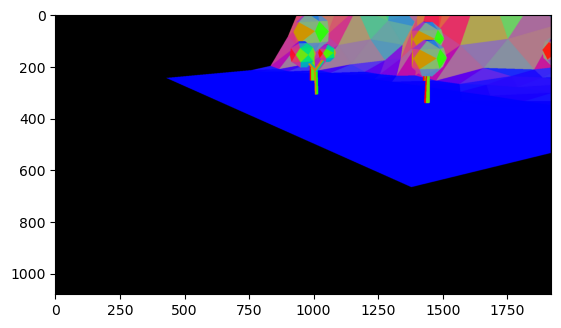

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from easymocap.mytools.camera_utils import write_camera, read_camera
import pywavefront
from tqdm import tqdm
root = r"C:\Users\flori\EasyMocap\data\wildtrack"
file = r"C:\Users\flori\EasyMocap\data\wildtrack\mesh-bg\FirstPoly.obj"

camera_id = "3"

scene = pywavefront.Wavefront(file, collect_faces=True)
scene.parse()
print(len(scene.vertices))



#for name, material in scene.materials.items():
#    print("Material name: " + name)
#    print("Diffuse: " + str(material.diffuse))
#
#for mesh in scene.mesh_list:
#    print("Mesh name: " + mesh.name)
#    print(mesh.faces)
#    print("Triangle count: {}".format(len(mesh.faces)))
    
cams = read_camera(root + "/intri.yml", root + "/extri.yml", ["1", "2", "3", "4", "5", "6", "7"])

    
P = np.dot(cams[camera_id]["K"], np.hstack((cams[camera_id]["R"], cams[camera_id]["T"])))

orig = np.array([0, 0, 0, 1])
orig = np.dot(P, orig)
orig = orig / orig[2]

image_path = root + f"/images/{camera_id}/000000.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.circle(image, (int(orig[0]), int(orig[1])), 10, (255, 0, 0), 2)
x_axis = np.array([1, 0, 0, 1])
y_axis = np.array([0, 1, 0, 1])
z_axis = np.array([0, 0, 1, 1])
x_axis = np.dot(P, x_axis)
y_axis = np.dot(P, y_axis)
z_axis = np.dot(P, z_axis)
x_axis = x_axis / x_axis[2]
y_axis = y_axis / y_axis[2]
z_axis = z_axis / z_axis[2]
x_axis = (int(x_axis[0]), int(x_axis[1]))
y_axis = (int(y_axis[0]), int(y_axis[1]))
z_axis = (int(z_axis[0]), int(z_axis[1]))
image = cv2.line(image, (int(orig[0]), int(orig[1])), x_axis, (255, 0, 0), 2)
image = cv2.line(image, (int(orig[0]), int(orig[1])), y_axis, (0, 255, 0), 2)
image = cv2.line(image, (int(orig[0]), int(orig[1])), z_axis, (0, 0, 255), 2)

                 

#for vertex in scene.vertices:
#    vertex = np.append(vertex, 1)
#    vertex = np.dot(P, vertex)
#    vertex = vertex / vertex[2]
#    image = cv2.circle(image, (int(vertex[0]), int(vertex[1])), 2, (0, 255, 0), 2)

R = cams[camera_id]["R"]
T = cams[camera_id]["T"]
cam_pos = -np.dot(R.T, T)

z_buffer = np.ones((image.shape[0], image.shape[1])) * np.inf
image = np.zeros_like(image)

def edge_function(v0, v1, v2):
    return (v1[...,0] - v0[...,0]) * (v2[...,1] - v0[...,1]) - (v1[...,1] - v0[...,1]) * (v2[...,0] - v0[...,0])

def clamp_to_int(x, a, b):
    return int(np.maximum(a, np.minimum(b, x)))

def rasterize_triangle(vertices, dist, W, H, z_buffer, rgb, img):
    # rasterize triangle
    min_x = clamp_to_int(np.min(vertices[:, 0]), 0, H-1)
    min_y = clamp_to_int(np.min(vertices[:, 1]), 0, W-1)

    max_x = clamp_to_int(np.max(vertices[:, 0]+1), 0, H-1)
    max_y = clamp_to_int(np.max(vertices[:, 1]+1), 0, W-1)
    
    if min_x == max_x or min_y == max_y:
        return None
    v1, v2, v3 = vertices
    A = edge_function(v1, v2, v3)
    if A < 0:
        return None
    
    
    
    xs, ys = np.meshgrid(np.arange(min_x, max_x), np.arange(min_y, max_y))
    pts = np.dstack((xs, ys))
    #print(f"[{min_x}:{max_x}, {min_y}:{max_y}]")
    w0 = edge_function(v2, v3, pts)
    w1 = edge_function(v3, v1, pts)
    w2 = edge_function(v1, v2, pts)
    mask = (w0 >= 0) & (w1 >= 0) & (w2 >= 0)
    mask = pts[mask]
    #print(mask)
    #print(f"mask {mask.shape}")
    #print(z_buffer.shape)
    dist_mask = dist < z_buffer[mask[:,1], mask[:,0]]
    #print(dist_mask)
    #print(dist_mask.shape)
    #print(mask.shape, dist_mask.shape)
    mask = mask[dist_mask]
    #print(f"z_buffer: {z_buffer[mask[:,1], mask[:,0]]}")
    z_buffer[mask[:,1], mask[:,0]] = dist
    #print(f"z_buffer: {z_buffer[mask[:,1], mask[:,0]]}")

    img[mask[:,1], mask[:,0]] = rgb
    #print(image[mask[:,1], mask[:,0]])
    
    """
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            P = np.array([x, y])
            w0 = edge_function(v2, v3, P)
            w1 = edge_function(v3, v1, P)
            w2 = edge_function(v1, v2, P)
            if w0 >= 0 and w1 >= 0 and w2 >= 0:
                if dist < z_buffer[y,x]:
                    z_buffer[y,x] = dist
                    image[y,x] = rgb
            
    """
    

scene.mesh_list.reverse()
for mesh in scene.mesh_list:
    print("Mesh name: " + mesh.name)
    #rgb = scene.materials[mesh.material].diffuse
    
    for face in tqdm(mesh.faces):
        
        vertices = [scene.vertices[i] for i in face]
        vertices = np.array(vertices)
        invert_yz = np.array([[1, 0, 0], [0, 0, 1], [0, 1, 0]])
        scale_10 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 
        translate = np.array([-10, -10 , 0])
        #transform = np.dot(np.dot(invert_yz, scale_10), vertices.T).T + translate
        vertices = np.dot(np.dot(invert_yz, scale_10), vertices.T).T + translate
        
        normal = np.cross(vertices[1] - vertices[0], vertices[2] - vertices[0])
        normal = normal / np.linalg.norm(normal)
        rgb = np.abs(normal) * 255
        
        v2d = np.dot(P, np.hstack((vertices, np.ones((3, 1)))).T)
        v2d = v2d[:2] / v2d[2]
        v2d = v2d.T # (x, y)
        
        #print(v2d)
        dist = np.linalg.norm(np.mean(vertices, axis=0) - cam_pos)
        #print("dist",dist)
        
        rasterize_triangle(v2d, dist, image.shape[0], image.shape[1], z_buffer, rgb, image)
        #print(triangle_mask, triangle_mask.shape)
        #print(v2d)
        #cv2.polylines(image, [v2d.astype(np.int32)], True, (255, 255, 255))
        #cv2.fillPoly(image, [v2d.astype(np.int32)], rgb)
        #plt.imshow(image)
        
        #image[triangle_mask] = rgb
        
        
        #raise ValueError("stop")
        
            

plt.imshow(image)

Material name: Material.001
Diffuse: [0.08, 0.56, 0.0, 1.0]
vertex_format N3F_V3F
271.0
Material name: Material.002
Diffuse: [0.230637, 0.031659, 0.0, 1.0]
vertex_format N3F_V3F
141.0
Material name: Material.003
Diffuse: [1.0, 1.0, 1.0, 1.0]
vertex_format N3F_V3F
101.0
Material name: Material.004
Diffuse: [0.0, 0.389517, 0.0, 1.0]
vertex_format N3F_V3F
296.0
Material name: Material.006
Diffuse: [0.10258, 0.006399, 0.0, 1.0]
vertex_format N3F_V3F
180.0
(559, 3)


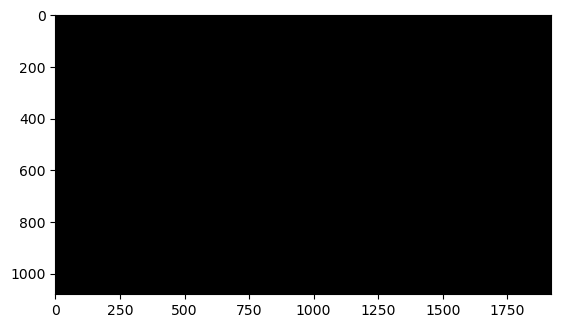

In [39]:

for name, material in scene.materials.items():
    print("Material name: " + name)
    print("Diffuse: " + str(material.diffuse))
    print("vertex_format", material.vertex_format)
    if material.vertex_format == "N3F_V3F":
        vertices = np.array(material.vertices)
        print(vertices.shape[0]/18)
    
print(np.array(scene.vertices).shape)
        
plt.imshow(image)